# Table of Contents
```
1. Business Understanding
   1.1. Problem Description
2. Data Understanding
   2.1. Import Libraries, Modules, Functions, Objects, etc.
   2.2. User Defined Functions (UDFs)
   2.3. Data Loading
   2.4. Exploratory Data Analysis (EDA)
        2.4.1. Text EDA: Understand the raw data with Descriptive Statistics
        2.4.2. Visual EDA: Understand the data with Visualizations
               2.4.2.1. Draw Univariate plots to better understand each attribute
               2.4.2.2. Draw Multivariate plots to better understand the relationship between attributes
3. Research
   3.1. List of selected algorithms to build models
   3.2. List of model evaluation metrics
4. Data Preprocessing
   4.1. Data Cleaning
        4.1.1. Basic data cleaning
        4.1.2. Outliers detection
   4.2. Feature Selection
   4.3. Feature Engineering
   4.4. Dimensionality Reduction
   4.5. Split datasets for train-test
        4.5.1. Create Independent(X) and Dependent(y) variables
        4.5.2. Split the dataset into train and test
        4.5.3. Outliers removal (replace with mean)
   4.6. Data Transforms
        4.6.1. Transforming Numerical type
   4.7. Handling Imbalanced classes
5. Model Development
   5.1. Model definitions
6. Model Training
7. Model Refinement
   7.1. Hyperparameters Optimization with Grid Search
8. Model Evaluation
9. Final Model Selection
10. Model Validation
11. Model Deployment
```

# 1. Business Understanding

## 1.1. Problem Description

**`Problem statement`**:

`In business terms`: 

* Based on certain diagnostic measurement such as glucose level, insulin level, BP, BMI, Age, etc., predict whether or not a patient has diabetes.

`In analytical terms`: 

* Build a predictive model to predict whether a patient has diabetes or not, given the diagnostic measurement details.

Input data are in `data/PimaIndiansDiabetes.txt`, UAT data are in `data/PimaIndiansDiabetes-uat.txt` and UAT validation data are in `data/PimaIndiansDiabetes-uat-val.txt`.

**`Type of the problem`**: Supervised Learning - Classification - Univariate

**`Data source(s)`**: [Kaggle](https://www.kaggle.com/)
    
**`Author(s)`**: Balasubramanian Chandran

# 2. Data Understanding

## 2.1. Import Libraries, Modules, Functions, Objects, etc.

In [1]:
# Import necessary libraries for this project
import sys         as sys
import numpy       as np
import pandas      as pd
import sklearn     as sk
import seaborn     as sns
import matplotlib  as mpl
import pickle      as pickle
import warnings

# Import necessary Modules, Functions and Objects from the Libraries
from numpy                         import loadtxt, percentile
from pandas                        import read_csv
from datetime                      import datetime
from collections                   import Counter
from imblearn.over_sampling        import SMOTE
from sklearn.metrics               import accuracy_score
from sklearn.metrics               import confusion_matrix, classification_report
from sklearn.preprocessing         import RobustScaler
from sklearn.model_selection       import cross_val_score, train_test_split
from sklearn.model_selection       import GridSearchCV, KFold, RepeatedStratifiedKFold
from matplotlib                    import pyplot as plt
from sklearn.linear_model          import LogisticRegression, SGDClassifier
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.svm                   import SVC
from sklearn.naive_bayes           import GaussianNB
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.ensemble              import RandomForestClassifier, GradientBoostingClassifier
from xgboost                       import XGBClassifier

# Check the versions of the imported libraries
print("Versions of imported libraries:")
print("Python:     {}".format(sys.version))
print("Numpy:      {}".format(np.__version__))
print("Pandas:     {}".format(pd.__version__))
print("skLearn:    {}".format(sk.__version__))
print("Seaborn:    {}".format(sns.__version__))
print("Matplotlib: {}".format(mpl.__version__))

# Optional settings
mpl.style.use('ggplot')
sns.set(style='whitegrid')
pd.set_option('display.max_columns', None, 'precision', 3)
warnings.filterwarnings('ignore')

print(__doc__)

Versions of imported libraries:
Python:     3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
Numpy:      1.19.5
Pandas:     1.3.2
skLearn:    0.24.2
Seaborn:    0.11.2
Matplotlib: 3.4.2
Automatically created module for IPython interactive environment


## 2.2. User Defined Functions (UDFs)

In [2]:
def plot_boxnwhiskers(df, features, rows, cols):
    fig = plt.figure(figsize=(10,8))
    sns.set_style('darkgrid')
    k=0
    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows,cols,i+1)
        sns.boxplot(y=df.columns[k], data=df, orient='v', palette='Set2')
        k = k+1
        fig.tight_layout()  
    plt.show()

def plot_histograms(df, features, rows, cols):
    fig = plt.figure(figsize=(10,8))
    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows,cols,i+1)
        df[feature].hist(bins=20, ax=ax, facecolor='midnightblue')
        ax.set_title(feature, color='brown', size='large')
    #ax.set_yscale('log')
    fig.tight_layout()  
    plt.show()

def plot_correlationmap(df):
    corr = df.corr()
    plt.figure(figsize = (10,8))
    sns.heatmap(corr, annot=True, cmap='GnBu', mask=corr<0.1)

def detect_outliers(df, col):
    q25      = percentile(df[col], 25)
    q75      = percentile(df[col], 75)
    iqr      = q75 - q25
    cutoff   = iqr * 1.5
    lower    = q25 - cutoff
    upper    = q75 + cutoff
    mean     = df[col].mean()
    outliers = [x for x in df[col] if (x < lower or x > upper)]
    return q25, q75, iqr, cutoff, lower, upper, mean, outliers

def plot_performance_metrics(scores_list, scores_names, colors, modelnames):
    fig, axes = plt.subplots(1, len(scores_names), figsize=(12, 5))
    for i in range(len(scores_names)):
        axes[i].bar(modelnames, scores_list[i], color=colors[i])
        axes[i].set_title(scores_names[i], fontsize=15, alpha=0.6, pad=20)
    j = 0
    for scores in scores_list:
        xpos = 0
        for i in scores:
            text = str(i*100)[:5]
            axes[j].text(x=xpos, y=i, s=text, ha='center', va='bottom')
            for spine in axes[j].spines:
                axes[j].spines[spine].set_visible(False)
                axes[j].spines['left'].set_visible(True)
                axes[j].spines['left'].set_alpha(0.4)
                axes[j].spines['bottom'].set_visible(True)
                axes[j].spines['bottom'].set_alpha(0.4)
            xpos += 1
        j += 1
    plt.show()

def find_optimal_hyperparameters(model, space, X_in, y_in):
    rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=52)   # Define evaluation
    gs = GridSearchCV(model, space, cv=rskf, n_jobs=-1, scoring='accuracy')    # Define search
    result = gs.fit(X_in, y_in)                         # Execute search
    return result

## 2.3. Data Loading

In [3]:
## Load the necessary data files for this project ##
filename    = 'data/PimaIndiansDiabetes.txt'
colnames    = ['pregnancies', 'glucose', 'bp', 'skinthickness', 'insulin', 'bmi', 'pedigree', 'age', 'outcome']
diabetes_df = read_csv(filename, names=colnames)

## 2.4. Exploratory Data Analysis (EDA)

### 2.4.1. `Text EDA`: Understand the raw data with Descriptive Statistics

#### Dimensions of the `diabetes` dataset:

In [4]:
diabetes_df.shape

(768, 9)

#### Initial look at the raw data - First & Last 10 rows:

In [5]:
diabetes_df.head(10).style.background_gradient(cmap='Purples', axis='rows').highlight_null(null_color='brown')

,pregnancies,glucose,bp,skinthickness,insulin,bmi,pedigree,age,outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1
5,5,116,74,0,0,25.600,0.201,30,0
6,3,78,50,32,88,31.000,0.248,26,1
7,10,115,0,0,0,35.300,0.134,29,0
8,2,197,70,45,543,30.500,0.158,53,1
9,8,125,96,0,0,0.000,0.232,54,1


In [6]:
diabetes_df.tail(10).style.background_gradient(cmap='Purples', axis='rows').highlight_null(null_color='brown')

,pregnancies,glucose,bp,skinthickness,insulin,bmi,pedigree,age,outcome
758,1,106,76,0,0,37.500,0.197,26,0
759,6,190,92,0,0,35.500,0.278,66,1
760,2,88,58,26,16,28.400,0.766,22,0
761,9,170,74,31,0,44.000,0.403,43,1
762,9,89,62,0,0,22.500,0.142,33,0
763,10,101,76,48,180,32.900,0.171,63,0
764,2,122,70,27,0,36.800,0.340,27,0
765,5,121,72,23,112,26.200,0.245,30,0
766,1,126,60,0,0,30.100,0.349,47,1
767,1,93,70,31,0,30.400,0.315,23,0


#### Basic information of the dataset:

In [7]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pregnancies    768 non-null    int64  
 1   glucose        768 non-null    int64  
 2   bp             768 non-null    int64  
 3   skinthickness  768 non-null    int64  
 4   insulin        768 non-null    int64  
 5   bmi            768 non-null    float64
 6   pedigree       768 non-null    float64
 7   age            768 non-null    int64  
 8   outcome        768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


#### Statistical summary of the dataset:

In [8]:
diabetes_df.describe()

,pregnancies,glucose,bp,skinthickness,insulin,bmi,pedigree,age,outcome
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,3.845,120.895,69.105,20.536,79.799,31.993,0.472,33.241,0.349
std,3.370,31.973,19.356,15.952,115.244,7.884,0.331,11.760,0.477
min,0.000,0.000,0.000,0.000,0.000,0.000,0.078,21.000,0.000
25%,1.000,99.000,62.000,0.000,0.000,27.300,0.244,24.000,0.000
50%,3.000,117.000,72.000,23.000,30.500,32.000,0.372,29.000,0.000
75%,6.000,140.250,80.000,32.000,127.250,36.600,0.626,41.000,1.000
max,17.000,199.000,122.000,99.000,846.000,67.100,2.420,81.000,1.000


#### Class ditribution of the dataset:

In [9]:
Counter(diabetes_df.outcome)             # alternatively, use diabetes_df.groupby('outcome').size()

Counter({1: 268, 0: 500})

#### Explore NA / NULL values in the dataset:

In [10]:
null_values     = pd.DataFrame(data=diabetes_df.isnull().sum(), columns=['NULL Count'])
null_values_per = pd.DataFrame(round(diabetes_df.isnull().sum() / len(diabetes_df) * 100, 2), columns=['NULL Percentage'])
null_values_df  = pd.concat([null_values, null_values_per], axis=1)
null_values_df

,NULL Count,NULL Percentage
pregnancies,0,0.0
glucose,0,0.0
bp,0,0.0
skinthickness,0,0.0
insulin,0,0.0
bmi,0,0.0
pedigree,0,0.0
age,0,0.0
outcome,0,0.0


#### Explore duplicates in the dataset:

In [11]:
dup_df = diabetes_df.drop_duplicates()
print('Number of duplicates found:', (len(diabetes_df) - len(dup_df)))

Number of duplicates found: 0


### 2.4.2. `Visual EDA`: Understand the data with Visualizations

#### 2.4.2.1. Draw Univariate plots to better understand each attribute

#### Univariate - Box and Whisker plots:

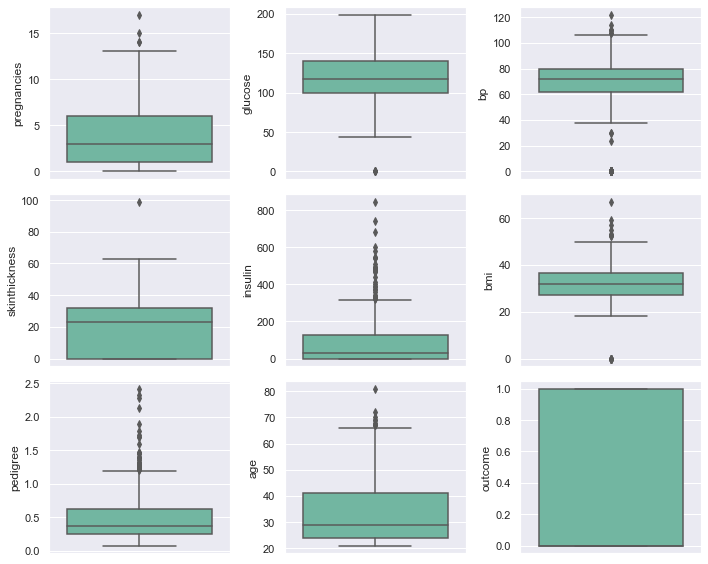

In [12]:
plot_boxnwhiskers(diabetes_df, diabetes_df.columns, 3, 3)

#### Univariate - Histograms:

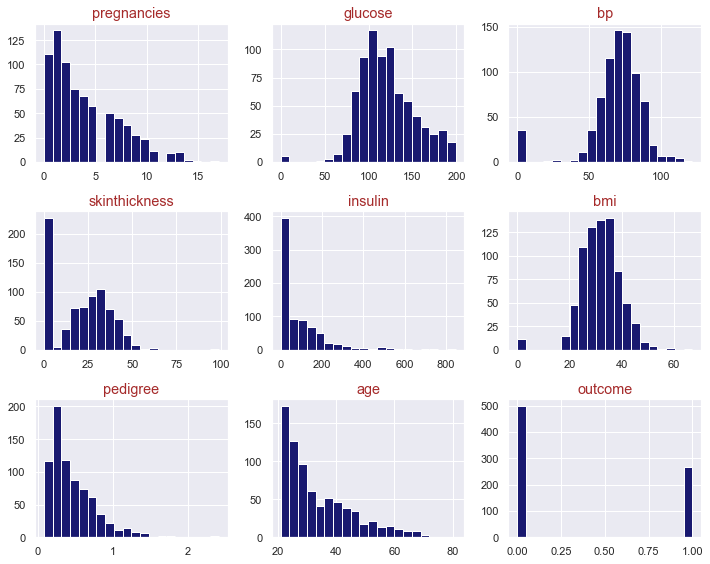

In [13]:
plot_histograms(diabetes_df, diabetes_df.columns, 3, 3)

#### 2.4.3.2. Draw Multivariate plots to better understand the relationship between attributes

#### Multivariate - Scatter Plot Matrix:

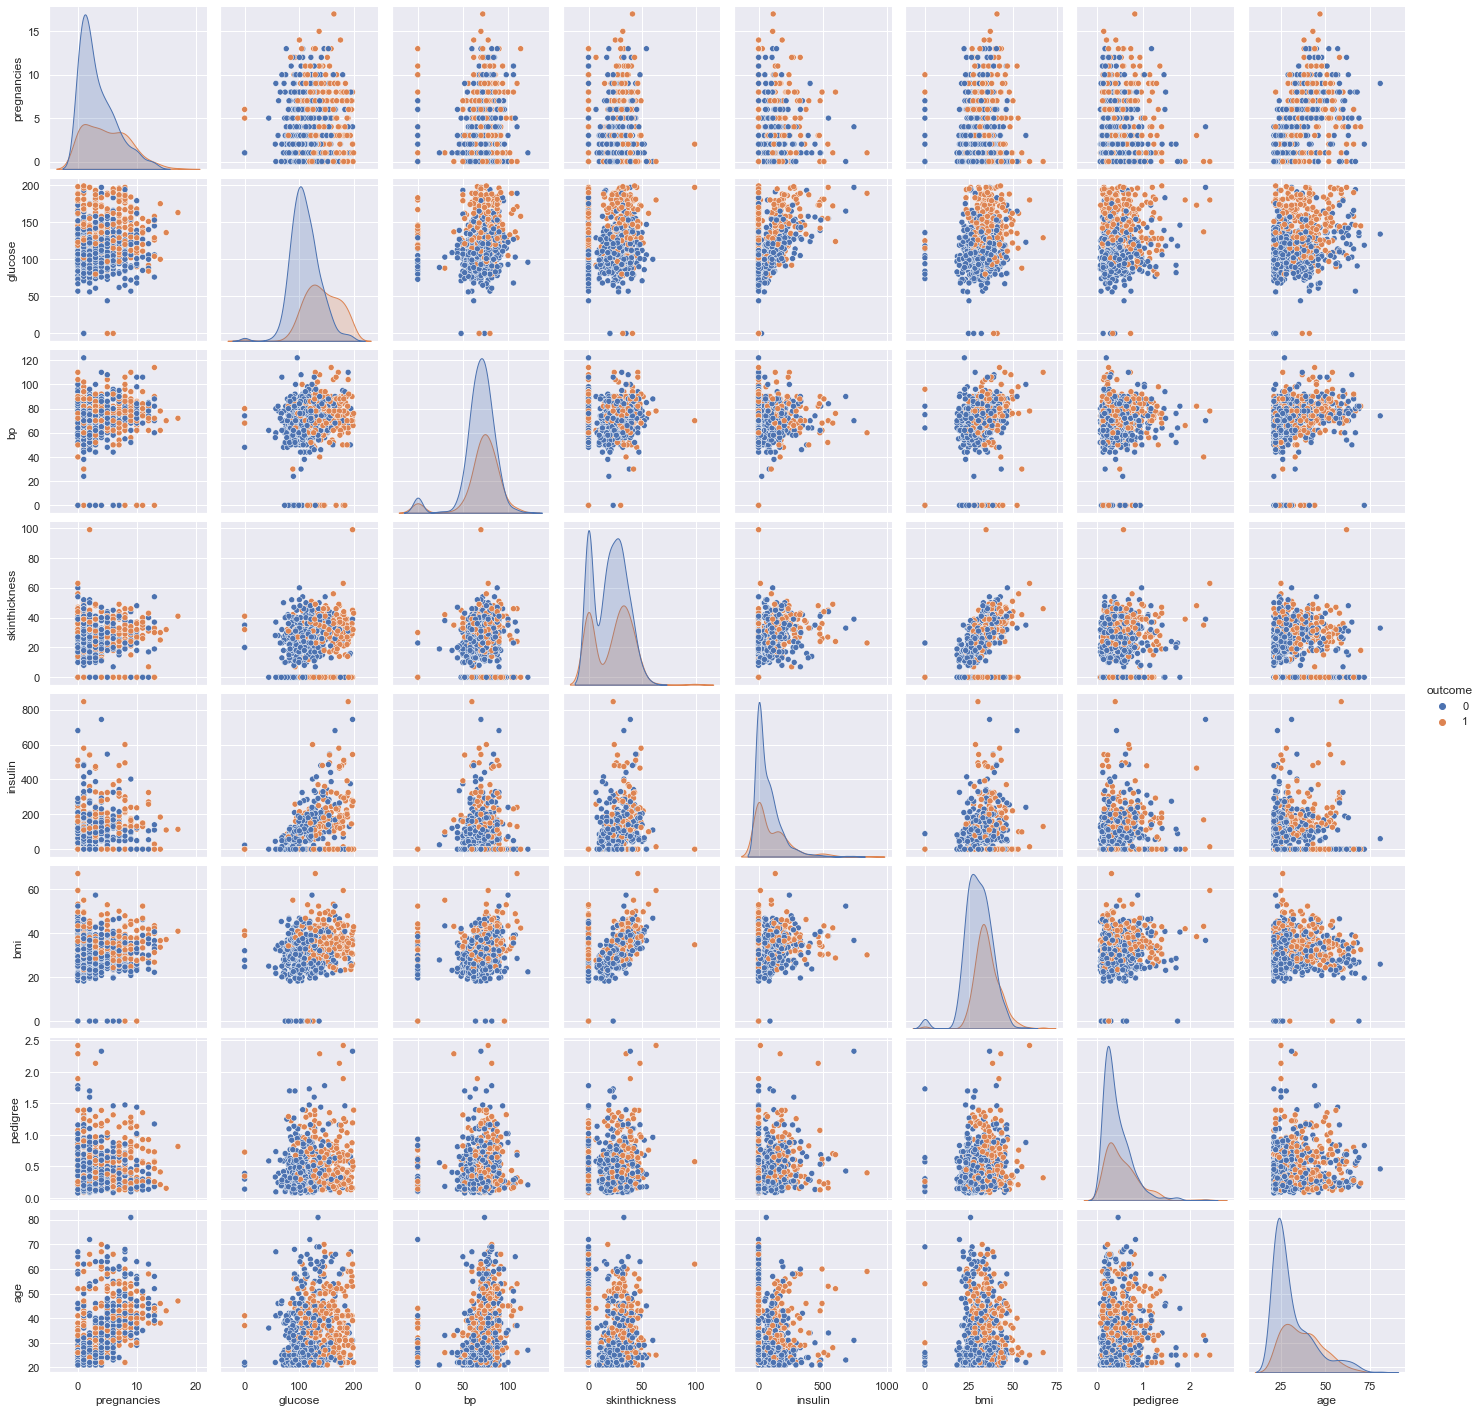

In [14]:
sns.pairplot(diabetes_df, hue='outcome')

#### Multivariate - Correlation map:

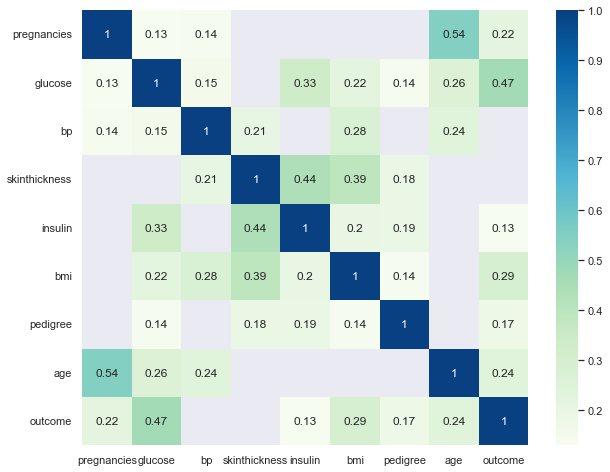

In [15]:
plot_correlationmap(diabetes_df)

# 3. Research

## 3.1. List of selected algorithms to build models

The following are the algorithms covering a variety of classification strategies and techniques that have been selected for the project. All models will be developed with default parameters and trained. Only a few best will be selected for algorithm tuning based on their performances (evaluation metrics). Then, each of those models will be individually tuned to minimize error. The final model will be selected based on their evaluation metrics on training and test datasets. 

#### Classification algorithms:
```
 1) Logistic Regression (LR)         LogisticRegression()            - Simple Linear
 2) SGD Classifier (SGD)             SGDClassifier()                 - Simple Linear
 3) K-Nearest Neighbors (KNN)        KNeighborsClassifier()          - Nonlinear
 4) Support Vector Machines (SVM)    SVC()                           - Nonlinear
 5) Gaussian Naive Bayes (NB)        GaussianNB()                    - Nonlinear
 6) Decision Trees (DT)              DecisionTreeClassifier()        - Nonlinear
 7) Random Forest Trees (RF)         RandomForestClassifier()        - Ensemble Bagging
 8) Gradient Boosting (GB)           GradientBoostingClassifier()    - Ensemble Boosting   
 9) Extreme Boosting (XGB)           XGBClassifier()                 - Ensemble Boosting
```

## 3.2. List of model evaluation metrics

#### Classification model evaluation metrics:
The following metrics have been selected as the `evaluation metrics` for training, refining and evaluating the models.
```
1) Accuracy score
```
Though the following are not metrics, they help to gain insight into the type of errors a model is making.
```
2) Confusion matrix
3) Classification report (produces Precision, Recall, F1 scores)
```

# 4. Data Preprocessing

## 4.1. Data Cleaning

### 4.1.1. Basic data cleaning

The `diabetes` dataset is pretty clean and does not have the following, and so no basic cleaning needs to be done:
* Duplicate features/columns
* Duplicate samples/rows
* Embedded characters causing data misalignment
* Inconsistent data

### 4.1.2. Outliers detection

In [16]:
collist = ['feature', '25%', '75%,', 'IQR', 'cutoff', 'lower', 'upper', 'mean', '# of outliers', 'outliers']
out_df  = pd.DataFrame(columns=collist)

for i, col in enumerate(diabetes_df):
    q25, q75, iqr, cutoff, lower, upper, mean, outlierslist = detect_outliers(diabetes_df, col)
    tmp_df = pd.DataFrame([[col, q25, q75, iqr, cutoff, lower, upper, mean, len(outlierslist), outlierslist]], columns=collist)
    out_df = out_df.append(tmp_df, ignore_index=True)

out_df.style.hide_index()

feature,25%,"75%,",IQR,cutoff,lower,upper,mean,# of outliers,outliers
pregnancies,1.000,6.000,5.000,7.500,-6.500,13.500,3.845,4,"[15, 17, 14, 14]"
glucose,99.000,140.250,41.250,61.875,37.125,202.125,120.895,5,"[0, 0, 0, 0, 0]"
bp,62.000,80.000,18.000,27.000,35.000,107.000,69.105,45,"[0, 0, 30, 110, 0, 0, 0, 0, 108, 122, 30, 0, 110, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 108, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 110, 0, 24, 0, 0, 0, 0, 114, 0, 0, 0]"
skinthickness,0.000,32.000,32.000,48.000,-48.000,80.000,20.536,1,[99]
insulin,0.000,127.250,127.250,190.875,-190.875,318.125,79.799,34,"[543, 846, 342, 495, 325, 485, 495, 478, 744, 370, 680, 402, 375, 545, 360, 325, 465, 325, 415, 579, 474, 328, 480, 326, 330, 600, 321, 440, 540, 480, 335, 387, 392, 510]"
bmi,27.300,36.600,9.300,13.950,13.350,50.550,31.993,19,"[0.0, 0.0, 0.0, 0.0, 53.2, 55.0, 0.0, 67.1, 52.3, 52.3, 52.9, 0.0, 0.0, 59.4, 0.0, 0.0, 57.3, 0.0, 0.0]"
pedigree,0.244,0.626,0.382,0.574,-0.330,1.200,0.472,29,"[2.288, 1.441, 1.39, 1.893, 1.781, 1.222, 1.4, 1.321, 1.224, 2.329, 1.318, 1.213, 1.353, 1.224, 1.391, 1.476, 2.137, 1.731, 1.268, 1.6, 2.42, 1.251, 1.699, 1.258, 1.282, 1.698, 1.461, 1.292, 1.394]"
age,24.000,41.000,17.000,25.500,-1.500,66.500,33.241,9,"[69, 67, 72, 81, 67, 67, 70, 68, 69]"
outcome,0.000,1.000,1.000,1.500,-1.500,2.500,0.349,0,[]


## 4.2. Feature Selection

The `diabetes` dataset is pretty clean and has only 8 independent features, so it does not require feature selection process.

## 4.3. Feature Engineering

The `diabetes` dataset is pretty clean and has only 8 independent features, so it does not require feature engineering process.

## 4.4. Dimensionality Reduction

The `diabetes` dataset is pretty clean and has only 8 independent features, so it does not require dimensionality reduction process.

## 4.5. Split datasets for train-test

#### Keep only one dataframe (df) and delete the rest and release memory for ML processing

In [17]:
del null_values, null_values_per, null_values_df, dup_df, tmp_df, out_df

### 4.5.1. Create Independent(X) and Dependent(y) variables

In [18]:
X = diabetes_df.drop(['outcome'], axis=1)   # Independent variables
y = diabetes_df['outcome']                  # Dependent variable

### 4.5.2. Split the dataset into *`train`* and *`test`*

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print('X_train:', X_train.shape)
print('X_test :', X_test.shape)
print('y_train:', y_train.shape)
print('y_test :', y_test.shape)
print('X      :', X.shape)
print('y      :', y.shape)

X_train: (537, 8)
X_test : (231, 8)
y_train: (537,)
y_test : (231,)
X      : (768, 8)
y      : (768,)


### 4.5.3. Outliers removal (replace with `mean`)

In [20]:
X_train_outr = X_train
X_test_outr  = X_test
X_outr       = X

#### `X_train` Box and Whistker plots *before* Outliers removal:

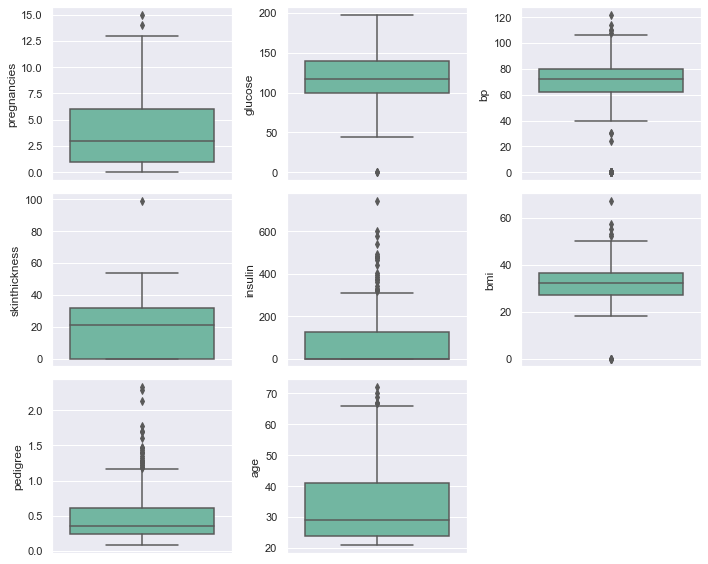

In [21]:
plot_boxnwhiskers(X_train, X_train.columns, 3, 3)

#### `X_train` - Box and Whistker plots *after* Outliers removal:

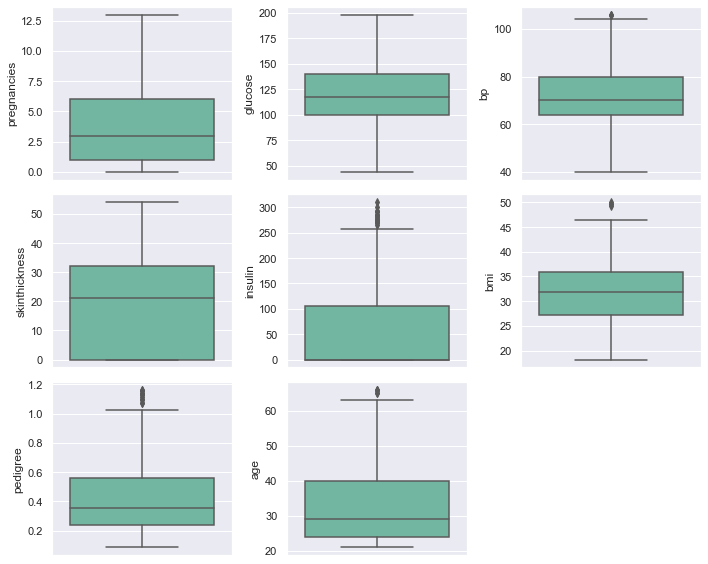

In [22]:
for i, col in enumerate(X_train_outr):
    q25, q75, iqr, cutoff, lower, upper, mean, outlierlist = detect_outliers(X_train_outr, col)
    X_train_outr[col] = [mean if (x < lower or x > upper) else x for x in X_train_outr[col]]

plot_boxnwhiskers(X_train_outr, X_train_outr.columns, 3, 3)

#### `X_test` - Box and Whistker plots *before* Outliers removal:

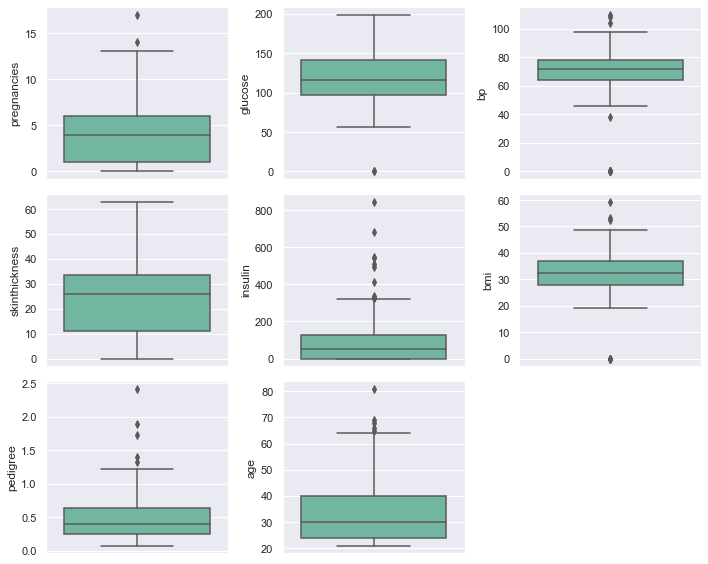

In [23]:
plot_boxnwhiskers(X_test, X_test.columns, 3, 3)

#### `X_test` - Box and Whistker plots *after* Outliers removal:

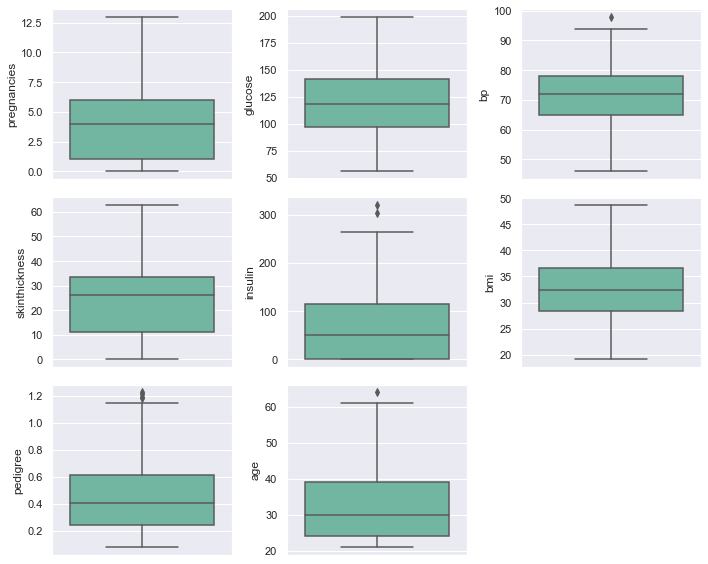

In [24]:
for i, col in enumerate(X_test_outr):
    q25, q75, iqr, cutoff, lower, upper, mean, outlierlist = detect_outliers(X_test_outr, col)
    X_test_outr[col] = [mean if (x < lower or x > upper) else x for x in X_test_outr[col]]

plot_boxnwhiskers(X_test_outr, X_test_outr.columns, 3, 3)

#### `X` Box and Whisker plots *before* Outliers removal

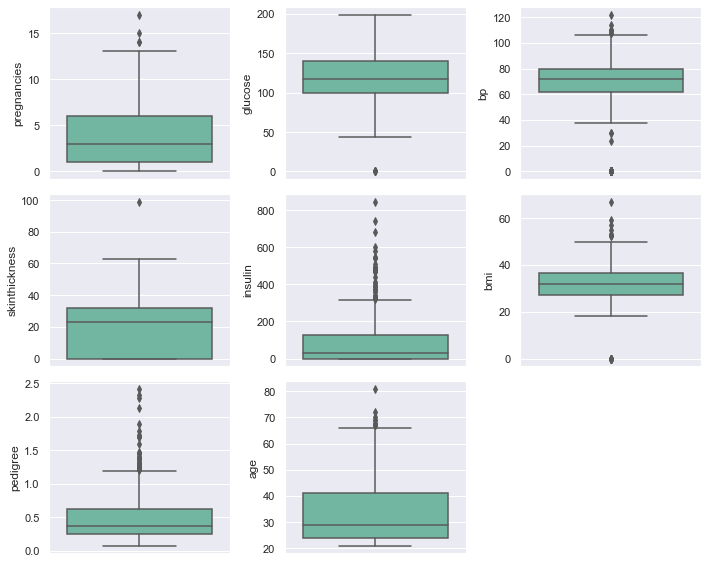

In [25]:
plot_boxnwhiskers(X, X.columns, 3, 3)

#### `X` Box and Whisker plots *after* Outliers removal

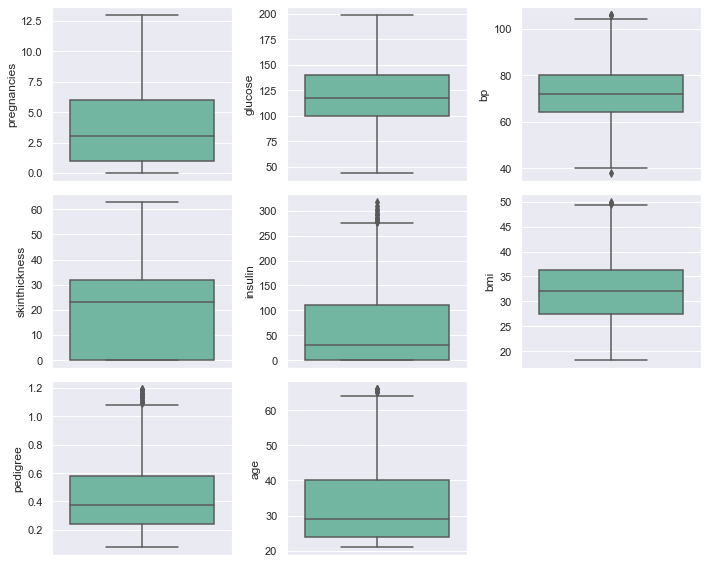

In [26]:
for i, col in enumerate(X_outr):
    q25, q75, iqr, cutoff, lower, upper, mean, outlierlist = detect_outliers(X_outr, col)
    X_outr[col] = [mean if (x < lower or x > upper) else x for x in X_outr[col]]

plot_boxnwhiskers(X_outr, X_outr.columns, 3, 3)

## 4.6. Data Transforms

### 4.6.1. Transforming `Numerical type`

#### Robust scaling (Change scale)

In [27]:
rs = RobustScaler()
X_train_norm = rs.fit_transform(X_train_outr)   # To evaluate and select few models for improvement
X_test_norm  = rs.transform(X_test_outr)        # To evaluate and select the final model
X_norm       = rs.fit_transform(X_outr)         # To train the final model on the entire dataset

## 4.7. Handling Imbalanced classes

#### Resample datasets using SMOTE and make the samples balanced for better learning

In [28]:
X_train_norm_smote, y_train_smote = SMOTE().fit_resample(X_train_norm, y_train)
X_norm_smote, y_smote             = SMOTE().fit_resample(X_norm, y)

# 5. Model Development

## 5.1. Model definitions

In [29]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('SGD', SGDClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC()))
models.append(('NB', GaussianNB()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('XGB', XGBClassifier()))

# 6. Model Training

#### Train the models using `training datasets` and generate `performance metrics`

In [30]:
modelnames_trng = []
y_preds         = []
scores_trng     = []
scores_trng_sd  = []

print('Training the developed models in progress:')
start_time = datetime.now()

# Train the models and generate performance metrics
for name, model in models:
    stime = datetime.now()
    rskf       = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=5)
    cv_results = cross_val_score(model, X_train_norm_smote, y_train_smote, cv=rskf, scoring='accuracy')
    modelnames_trng.append(name)
    scores_trng.append(np.mean(cv_results))
    scores_trng_sd.append(cv_results.std())
    etime = datetime.now()
    print('%15s  Training complete...  ' % name, (etime - stime))

end_time     = datetime.now()
elapsed_time = end_time - start_time
print('\nTotal elapsed time: ', elapsed_time, '\n')

Training the developed models in progress:
             LR  Training complete...   0:00:00.225092
            SGD  Training complete...   0:00:00.150599
            KNN  Training complete...   0:00:00.204451
            SVM  Training complete...   0:00:00.908603
             NB  Training complete...   0:00:00.074769
             DT  Training complete...   0:00:00.146654
             RF  Training complete...   0:00:07.489692
             GB  Training complete...   0:00:05.653850
            XGB  Training complete...   0:00:03.019398

Total elapsed time:  0:00:17.873108 



#### Performance metrics generated during model-training using *X_train_norm_smote* & *y_train_norm_smote*

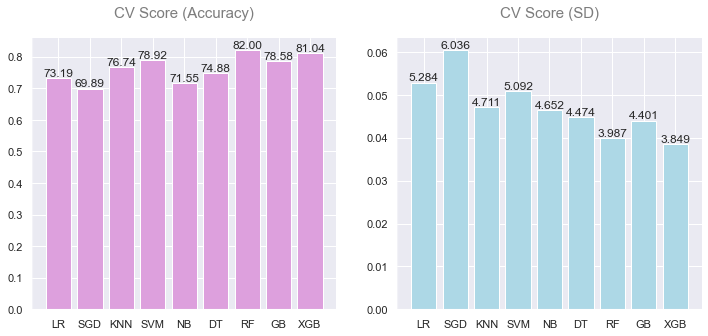

In [31]:
# Plot and compare scores
scores_list  = [scores_trng, scores_trng_sd]
scores_names = ['CV Score (Accuracy)', 'CV Score (SD)']
colors       = ['plum', 'lightblue']

plot_performance_metrics(scores_list, scores_names, colors, modelnames_trng)

Cut-off values considered for initial model selection are:

    CV Score (Accuracy) cut-off:   > 78
    CV Score (SD) cut-off      :   < 5

Based on the training performance metrics, the following models are selected for model-tuning.

    1) Support Vector Machine (SVM)
    2) Random Forest (RF)
    3) Gradient Boosting (GB)
    4) Extreme Boosting (XGB)

# 7. Model Refinement

## 7.1. Hyperparameters Optimization with Grid Search

#### Supprt Vector Machine (SVM):

In [32]:
model           = SVC()                                             # Define model
space           = dict()                                            # Define search space
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C']      = [100, 10, 1.0, 0.1, 0.001]
result_svm      = find_optimal_hyperparameters(model, space, 
                                               X_train_norm_smote, 
                                               y_train_smote)        # Find the optimal hyperparameters

#### Random Forest (RF):

In [33]:
model                 = RandomForestClassifier()                    # Define model
space                 = dict()                                      # Define search space
space['max_features'] = ['sqrt', 'log2']
space['n_estimators'] = [10, 100, 1000]
result_rf             = find_optimal_hyperparameters(model, space,
                                                    X_train_norm_smote,
                                                    y_train_smote)  # Find the optimal hyperparameters

#### Gradient Boosting (GB):

In [34]:
model              = GradientBoostingClassifier()                   # Define model
space              = dict()                                         # Define search space
space['subsample'] = [0.5, 0.7, 1.0]
space['max_depth'] = [3, 7, 9]
result_gb          = find_optimal_hyperparameters(model, space,
                                                 X_train_norm_smote,
                                                 y_train_smote)     # Find the optimal hyperparameters

#### Extreme Boosting (XGB):

In [35]:
model              = XGBClassifier()                                # Define model
space              = dict()                                         # Define search space
space['eta']       = [0.001, 0.01, 0.1, 0.2, 0.3]
space['subsample'] = [0.5, 0.7, 1.0]
result_xgb         = find_optimal_hyperparameters(model, space, 
                                                 X_train_norm_smote, 
                                                 y_train_smote)     # Find the optimal hyperparameters

#### Performance metrics generated during model-tuning using X_train_norm_smote & y_train_norm_smote

In [36]:
# Print and compare scores
modelnames_rfnd = ['SVM', 'RF', 'GB', 'XGB']
scores_rfnd     = [result_svm.best_score_, result_rf.best_score_, result_gb.best_score_, result_xgb.best_score_]
best_params     = [result_svm.best_params_, result_rf.best_params_, result_gb.best_params_, result_xgb.best_params_]

print('Model name   Best Score   Best Params')
print('----------   ----------   ----------------------------------------------')
for i in range(len(modelnames_rfnd)):
    print('%10s       %6.3f   %s' % (modelnames_rfnd[i], scores_rfnd[i]*100, best_params[i]))

Model name   Best Score   Best Params
----------   ----------   ----------------------------------------------
       SVM       79.636   {'C': 100, 'kernel': 'rbf'}
        RF       82.715   {'max_features': 'sqrt', 'n_estimators': 1000}
        GB       81.780   {'max_depth': 9, 'subsample': 0.5}
       XGB       81.442   {'eta': 0.1, 'subsample': 0.7}


# 8. Model Evaluation

In [43]:
svm_kernel      = 'rbf'
svm_c           = 100
rf_max_features = 'sqrt'
rf_n_estimators = 1000
gb_max_depth    = 9
gb_subsample    = 0.5
xgb_eta         = 0.1
xgb_subsample   = 0.7

### SUPPORT VECTOR MACHINE ###
clfsvm          = SVC(kernel=svm_kernel, C=svm_c).fit(X_train_norm_smote, y_train_smote)    
predsvm         = clfsvm.predict(X_test_norm)
eval_score_svm  = accuracy_score(y_test, predsvm)

### RANDOM FOREST ###
clfrf           = RandomForestClassifier(max_features=rf_max_features, 
                                         n_estimators=rf_n_estimators).fit(X_train_norm_smote, y_train_smote)    
predrf          = clfrf.predict(X_test_norm)
eval_score_rf   = accuracy_score(y_test, predrf)

### GRADIENT BOOSTING ###
clfgb           = GradientBoostingClassifier(max_depth=gb_max_depth, 
                                             subsample=gb_subsample).fit(X_train_norm_smote, y_train_smote)    
predgb          = clfgb.predict(X_test_norm)
eval_score_gb   = accuracy_score(y_test, predgb)

### EXTREME GRADIENT BOOSTING ###
clfxgb          = XGBClassifier(eta=xgb_eta, subsample=xgb_subsample).fit(X_train_norm_smote, y_train_smote)    
predxgb         = clfxgb.predict(X_test_norm)
eval_score_xgb  = accuracy_score(y_test, predxgb)

In [44]:
scores_eval = [eval_score_svm, eval_score_rf, eval_score_gb, eval_score_xgb]
print('Model name   Best Score')
print('----------   ----------')
for i in range(len(modelnames_rfnd)):
    print('%10s       %6.3f' % (modelnames_rfnd[i], scores_eval[i]*100))

Model name   Best Score
----------   ----------
       SVM       70.563
        RF       80.087
        GB       77.922
       XGB       76.623


# 9. Final Model Selection

Following are the `performance metrics` generated during,
* Stage-6: Model Training using *training datasets*
* Stage-7: Model Refinement using *training datasets*
* Stage-8: Model Evaluation using *test datasets*

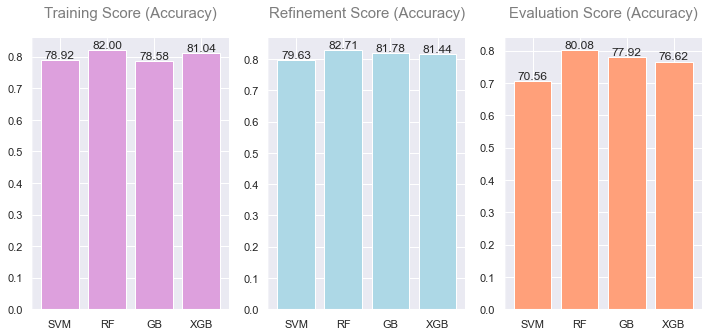

In [45]:
# Plot and compare scores
scores_trng_selected = [scores_trng[3], scores_trng[6], scores_trng[7], scores_trng[8]]
scores_list  = [scores_trng_selected, scores_rfnd, scores_eval]
scores_names = ['Training Score (Accuracy)', 'Refinement Score (Accuracy)', 'Evaluation Score (Accuracy)']
colors       = ['plum', 'lightblue', 'lightsalmon']
modelnames   = ['SVM', 'RF', 'GB', 'XGB']

plot_performance_metrics(scores_list, scores_names, colors, modelnames)

In [46]:
print('\nConfusion Matrix for RANDOM FOREST: \n', confusion_matrix(y_test, predrf))
print('\nClassification Report for RANDOM FOREST: \n', classification_report(y_test, predrf))


Confusion Matrix for RANDOM FOREST: 
 [[119  27]
 [ 19  66]]

Classification Report for RANDOM FOREST: 
               precision    recall  f1-score   support

           0       0.86      0.82      0.84       146
           1       0.71      0.78      0.74        85

    accuracy                           0.80       231
   macro avg       0.79      0.80      0.79       231
weighted avg       0.81      0.80      0.80       231



The scores generated at various stages suggest that the **`Random Forest`** *is the clear winner*. RF is the best model and it is selected as the final model. RF will be trained on the entire dataset, saved, and deployed into the test infrastructure for business user's testing (i.e., Model Validation).

In [47]:
# Train the final model on the entire dataset and save it to the disk
FinalModel = RandomForestClassifier(max_features=rf_max_features, n_estimators=rf_n_estimators).fit(X_norm, y)
ModelName = 'MLPy-DemoProj-1.sav'
pickle.dump(FinalModel, open(ModelName, 'wb'))

# 10. Model Validation

The business users perform the validations using the *`unseen UAT datasets`*.

In [48]:
# Load the model from the disk and Use it on the real/ unseen data
uat_data_filename   = 'data/PimaIndiansDiabetes-uat.txt'
uat_val_filename    = 'data/PimaIndiansDiabetes-uat-val.txt'
unseen_diabetes     = loadtxt(uat_data_filename, delimiter=',')
unseen_diabetes_val = read_csv(uat_val_filename, header=None)

unseen_diabetes_norm = RobustScaler().fit_transform(unseen_diabetes)
FinalModel_loaded    = pickle.load(open(ModelName, 'rb'))
pred_final           = FinalModel_loaded.predict(unseen_diabetes_norm)

print('Predicted result(s): ', pred_final)
print('Accuracy Score: %.2f%%' % (accuracy_score(unseen_diabetes_val, pred_final)*100))
print('\nConfusion Matrix: \n', confusion_matrix(unseen_diabetes_val, pred_final))
print('\nClassification Report: \n', classification_report(unseen_diabetes_val, pred_final))

Predicted result(s):  [1 0 1 0 1 0 0 0]
Accuracy Score: 87.50%

Confusion Matrix: 
 [[4 0]
 [1 3]]

Classification Report: 
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.75      0.86         4

    accuracy                           0.88         8
   macro avg       0.90      0.88      0.87         8
weighted avg       0.90      0.88      0.87         8



# 11. Model Deployment

The model deployment is usually done by the DS team along with the ML team upon receipt of stakeholders sign-off.